
# Project: Investigating no-show medical appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#structure">Data Structure</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Vitoria, Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

In this analysis, I'll try to evaluate:

- What are the proportions of each attribute in the sample;
- What are the waiting times, the biggest and lowest waiting times by neighbourhood;
- The neighbourhood with the most and the littlest appointments;
- Verify correlation between waiting times and total appointments;
- The distribution of appointments by weekday;
- Attendance rates: what are the general attendance rate, and how each attribute affects the attendance rate;

<a id='structure'></a>
## Data Structure: ##

The received CSV has the following structure:

- PatientId: Identification of a patient 
- AppointmentID: Identification of each appointment 
- Gender: M or F
- ScheduledDay: The date someone requested the appointment.
- AppointmentDay: Actual Appointment Date - **Does not contain appointment time.**
- Age: How old is the patient. 
- Neighbourhood: Location where the appointment takes place. 
- Scholarship: 0 (False) or 1 (True) - Indicates if the patient's family is enrolled in Brazilian welfare program [Bolsa Familia](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
- Hipertension: 0 (False) or 1 (True)
- Diabetes: 0 (False) or 1 (True)
- Alcoholism: 0 (False) or 1 (True)
- Handcap:0 (False) or 1 (True)
- SMS_received: 1 or more messages sent to the patient. 
- No-show: Yes or No. (Yes if patient **did not**  attend, no if patient **did** attend to consultation)

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:

file='./noshowappointments-kagglev2-may-2016.csv'
no_show_appointments = pd.read_csv(file)

no_show_appointments.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [3]:
no_show_appointments.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [4]:
# Check if there are any NaN values
no_show_appointments.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [5]:
# First, let's start by correcting the column name 'Handcap' to 'Handicap'
# Also, change the column names 'SMS_received', 'AppointmentID', and 'No-show' to CamelCase for consistency:

no_show_appointments.rename({'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show':'NoShow', 'AppointmentID': 'AppointmentId'}, axis='columns', inplace=True)


In [6]:
no_show_appointments.describe()

,PatientId,AppointmentId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMSReceived
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Something Is not quite right in the handicap column: we can see in the describe above that the maximum value found is 4 - but the column is supposed to be binary(\*) (0/1). Let's take a better look.

(\*): as defined on [Medical Appointments No Shows](https://www.kaggle.com/joniarroba/noshowappointments)

In [7]:

no_show_appointments.groupby('Handicap').AppointmentId.count()

Handicap
0    108286
1      2042
2       183
3        13
4         3
Name: AppointmentId, dtype: int64

As we can se above, there are other values different than 0 or 1 in the handicap column - It may indicate the handicap type. As we don't have more information about that, I'll infer that:
- 0: No handicap;
- \>0: Some sort of handicap;

In [8]:
no_show_appointments.Handicap = pd.Series((no_show_appointments.Handicap != 0).map(int))

no_show_appointments.groupby('Handicap').AppointmentId.count()

Handicap
0    108286
1      2241
Name: AppointmentId, dtype: int64

Also, there's a problem with the `Age` column: at least one record has a recorded age of -1. Let's check it:

In [9]:
no_show_appointments.groupby('Age').AppointmentId.count().head(5)

Age
-1       1
 0    3539
 1    2273
 2    1618
 3    1513
Name: AppointmentId, dtype: int64

As there is a single record, we can safely remove it:

In [10]:
no_show_appointments = no_show_appointments[no_show_appointments.Age >= 0]

In [11]:
no_show_appointments.groupby('Age').AppointmentId.count().head(5)

Age
0    3539
1    2273
2    1618
3    1513
4    1299
Name: AppointmentId, dtype: int64

### Converting data and creating new column

The `ScheduledDay` and `AppointmentDay` columns are currently strings - let's convert them to datetime.

In [12]:
# Convert the dates on ScheduledDay and AppointmentDay to datetimes (currently strings)

no_show_appointments.ScheduledDay = pd.to_datetime(no_show_appointments.ScheduledDay)
no_show_appointments.AppointmentDay = pd.to_datetime(no_show_appointments.AppointmentDay)

no_show_appointments.head(5)

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We can see that unlike `ScheduledDay`, `AppointmentDay` does not include time, just the day - so, let's remove the time information from ScheduledDay to be consistent.

In [13]:
no_show_appointments.ScheduledDay = no_show_appointments.ScheduledDay.map(lambda sched: sched.floor(freq='D'))

In [14]:
# Calculate statistics for the difference between AppointmentDay and ScheculedDay
# The mapping is removing the time part from the ScheduledDay, because AppointmentDay does not have this information.

(no_show_appointments.AppointmentDay - no_show_appointments.ScheduledDay).describe()


count                     110526
mean     10 days 04:24:39.789370
std      15 days 06:07:14.979140
min            -6 days +00:00:00
25%              0 days 00:00:00
50%              4 days 00:00:00
75%             15 days 00:00:00
max            179 days 00:00:00
dtype: object

We can see from the statistics that we have some inconsistency: there's at least one record of `ScheduledDay` happening after the effective `AppointmentDay`. Let's take a look on how many records are affected:

In [15]:
no_show_appointments[no_show_appointments.ScheduledDay > no_show_appointments.AppointmentDay]

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
27033,7.839273e+12,5679978,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes
55226,7.896294e+12,5715660,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes
64175,2.425226e+13,5664962,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes
71533,9.982316e+14,5686628,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes
72362,3.787482e+12,5655637,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes


As there are no sufficient information about why these records have this discrepancy, and considering how small is the sample (5 occurrences in a 110000 population), it seems to be safe to remove them. 

In [16]:
no_show_appointments = no_show_appointments[no_show_appointments.ScheduledDay <= no_show_appointments.AppointmentDay]

In [17]:
(no_show_appointments.AppointmentDay - no_show_appointments.ScheduledDay).describe()

count                     110521
mean     10 days 04:25:27.412889
std      15 days 06:07:25.262183
min              0 days 00:00:00
25%              0 days 00:00:00
50%              4 days 00:00:00
75%             15 days 00:00:00
max            179 days 00:00:00
dtype: object

To speed up the analysis, let's add a column `intApptSched` that stores the number of days (as an integer) between the Appointment and the Scheduling.

In [18]:
no_show_appointments['intApptSched'] = (no_show_appointments.AppointmentDay - no_show_appointments.ScheduledDay).map(lambda delta: delta // pd.Timedelta(1, 'D'))


Change the column 'NoShow': currently, it says 'No' when the patient actually shows for the consultation. This 'double negative' is confusing. 

So, let's change the column name to 'Attended' and store a 0/1 value to False/True.

In [19]:
# Avoiding the double negative in the no-show column 
# (the 'no no-show' to indicate that the patient actually attended to the consultation)
def convert_noshow(appt):
    """
        Transforms the column 'no_show' to a column named 'attended',
        that contains 0/1 for False/True 
    """
    appt['Attended'] = 1 if appt['NoShow'] == 'No' else 0
    del appt['NoShow']
    return appt

attended_appointments = no_show_appointments.apply(convert_noshow, axis=1)

attended_appointments.head(5)

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMSReceived,intApptSched,Attended
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,1
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,1
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,1
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,1


<a id='eda'></a>
## Exploratory Data Analysis

### Attributes Statistics

#### Age Distribution

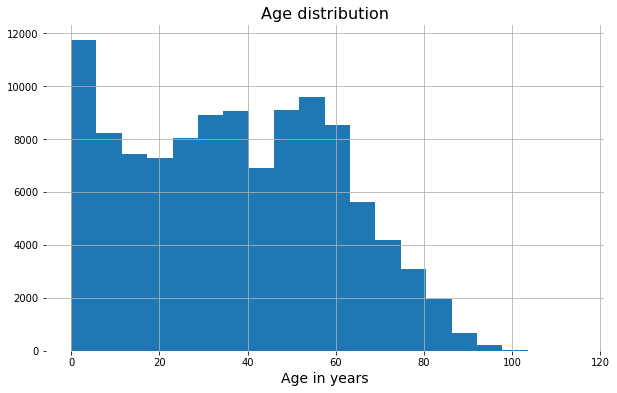

In [20]:
plt.figure(figsize=(10, 6))

plt.hist(
attended_appointments
        .Age,
        bins=20)

plt.title('Age distribution', fontsize=16)
plt.grid()
plt.xlabel('Age in years', fontsize=14)
sns.despine(bottom = True, left=True)

#### Percentages of attributes

Text(0,0.5,'')

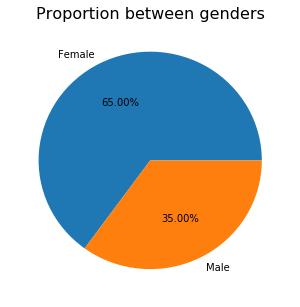

In [21]:
attended_appointments.groupby(['Gender']).AppointmentId.count().rename({'F':'Female', 'M':'Male'}).plot.pie(figsize=(5,5), autopct='%2.2f%%')

plt.title('Proportion between genders', fontsize=16)
plt.ylabel('')

Text(0.5,1,'Attributes distributions on data')

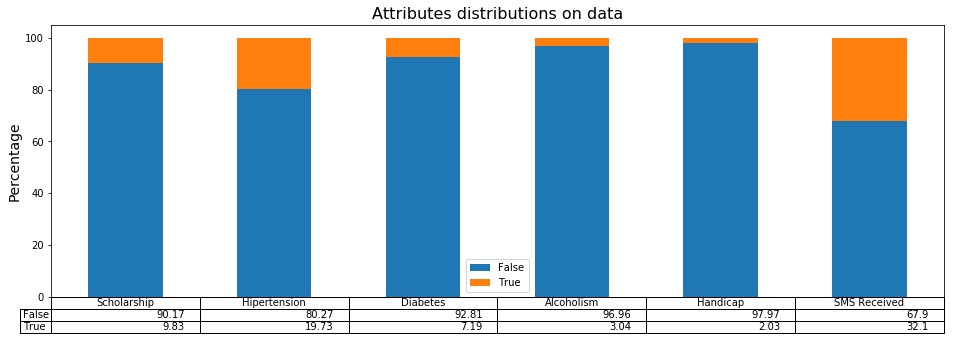

In [22]:
# fig, axarr = plt.subplots(3, 3, figsize=(16, 12))
proportions = pd.concat([
    pd.DataFrame(attended_appointments.groupby(['Scholarship']).AppointmentId.count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).transpose().rename({'AppointmentId': 'Scholarship'}).rename({0: 'False', 1:'True'}, axis =1),
    pd.DataFrame(attended_appointments.groupby(['Hipertension']).AppointmentId.count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).transpose().rename({'AppointmentId': 'Hipertension'}).rename({0: 'False', 1:'True'}, axis =1),
    pd.DataFrame(attended_appointments.groupby(['Diabetes']).AppointmentId.count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).transpose().rename({'AppointmentId': 'Diabetes'}).rename({0: 'False', 1:'True'}, axis =1),
    pd.DataFrame(attended_appointments.groupby(['Alcoholism']).AppointmentId.count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).transpose().rename({'AppointmentId': 'Alcoholism'}).rename({0: 'False', 1:'True'}, axis =1),
    pd.DataFrame(attended_appointments.groupby(['Handicap']).AppointmentId.count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).transpose().rename({'AppointmentId': 'Handicap'}).rename({0: 'False', 1:'True'}, axis =1),
    pd.DataFrame(attended_appointments.groupby(['SMSReceived']).AppointmentId.count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).transpose().rename({'AppointmentId': 'SMS Received'}).rename({0: 'False', 1:'True'}, axis =1),
    
]).plot.bar( stacked=True, figsize=(16, 5), table=True)

proportions.xaxis.set_visible(False)
proportions.set_ylabel('Percentage', fontsize=14)
proportions.set_title('Attributes distributions on data', fontsize=16)


### Waiting days distribution

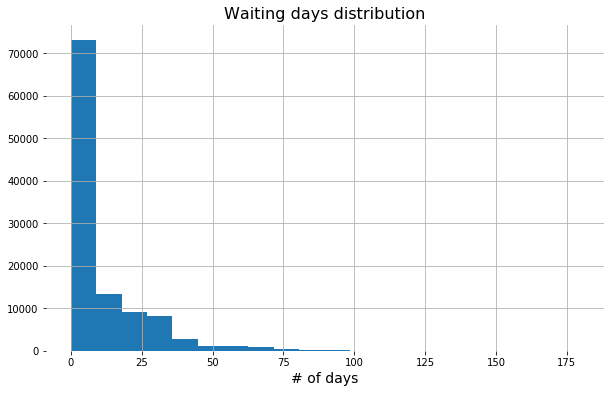

In [23]:
plt.figure(figsize=(10, 6))

waiting_days = plt.hist(
attended_appointments
        .intApptSched,
        bins=20)

plt.title('Waiting days distribution', fontsize=16)
plt.xlabel('# of days', fontsize=14)
plt.grid()
sns.despine(bottom = True, left=True)


We can see that the graph is clearly right-skewed, which seems to indicate that the mean is not a good choice for average times - let's take a look on how it compares to the median time.

In [24]:
pd.Series({"median": attended_appointments.intApptSched.median(),"mean": attended_appointments.intApptSched.mean()})

mean      10.184345
median     4.000000
dtype: float64

Based on that, we will be using the median instead of mean for the average of days.

Let's see what neighbourhoods have the highest and the lowest median waits:

Text(0.5,0,'Neighbourhood')

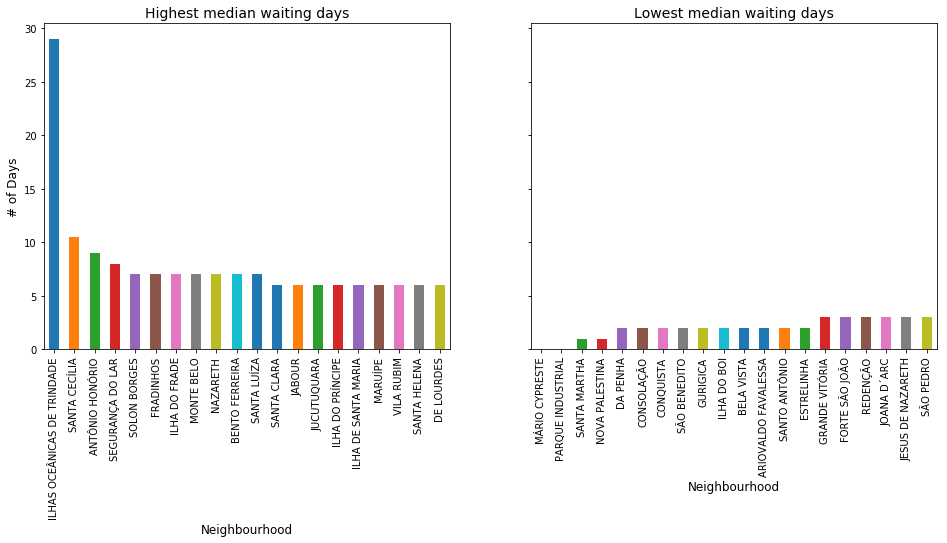

In [25]:
fig, axarr = plt.subplots(1, 2, sharey='row', figsize=(16, 6))


(attended_appointments
     .groupby(['Neighbourhood'])
     .intApptSched
     .median()
     .sort_values(ascending=False)
     .head(20)
     .plot.bar(ax=axarr[0])
)
axarr[0].set_title('Highest median waiting days', fontsize=14)
axarr[0].set_ylabel('# of Days', fontsize=12)
axarr[0].set_xlabel('Neighbourhood', fontsize=12)

(attended_appointments
     .groupby(['Neighbourhood'])
     .intApptSched
     .median()
     .sort_values()
     .head(20)
     .plot.bar(ax=axarr[1])
)
axarr[1].set_title('Lowest median waiting days', fontsize=14)
axarr[1].set_xlabel('Neighbourhood', fontsize=12)


Text(0.5,0,'Neighbourhood')

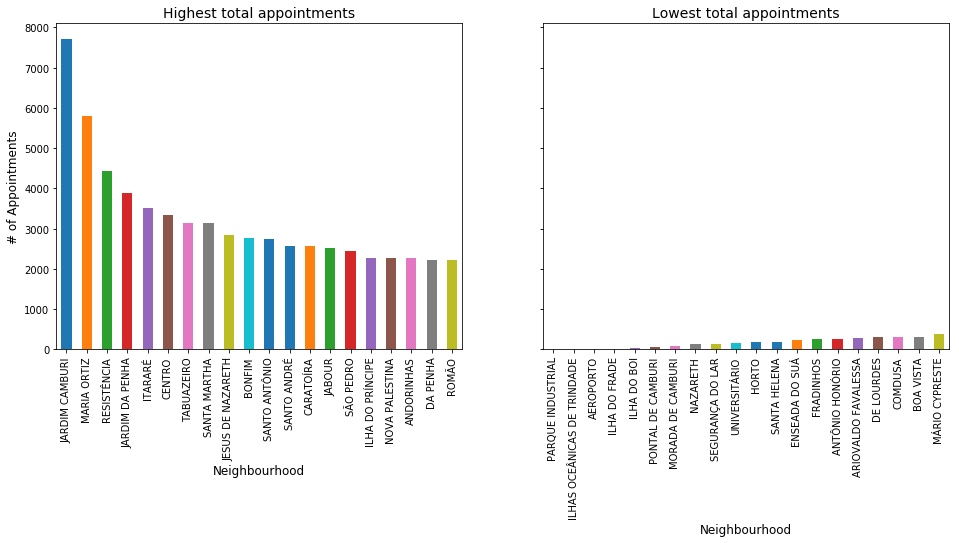

In [26]:
fig, axarr = plt.subplots(1, 2, sharey='row', figsize=(16, 6))


(attended_appointments
    .groupby('Neighbourhood')
    .AppointmentId.count()
    .sort_values(ascending=False)
    .head(20)
    .plot
    .bar(ax=axarr[0])
)
axarr[0].set_title('Highest total appointments', fontsize=14)
axarr[0].set_ylabel('# of Appointments', fontsize=12)
axarr[0].set_xlabel('Neighbourhood', fontsize=12)

(attended_appointments
    .groupby('Neighbourhood')
    .AppointmentId.count()
    .sort_values()
    .head(20)
    .plot
    .bar(ax=axarr[1])
)
axarr[1].set_title('Lowest total appointments', fontsize=14)
axarr[1].set_ylabel('# of Appointments', fontsize=12)
axarr[1].set_xlabel('Neighbourhood', fontsize=12)


Calculating Correlation between Total Appointments and Waiting Times:

In [27]:
(attended_appointments
    .groupby('Neighbourhood')['AppointmentId', 'intApptSched']
    .agg({'AppointmentId': pd.Series.count, 'intApptSched': np.median})
    .rename({'AppointmentId':'TotalAppointments', 'intApptSched': 'MedianWaitTime'}, axis=1)
).corr()

,TotalAppointments,MedianWaitTime
TotalAppointments,1.000000,-0.189272
MedianWaitTime,-0.189272,1.000000


The correlation matrix above seems to show a lower negative correlation between the wait times and the total appoitments.

In [28]:
by_weekday = attended_appointments.groupby(lambda x: attended_appointments.loc[x].AppointmentDay.weekday())

In [29]:
by_weekday.AppointmentId.count().rename({0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


Mon    22713
Tue    25638
Wed    25866
Thu    17246
Fri    19019
Sat       39
Name: AppointmentId, dtype: int64

Text(0,0.5,'# of appointments')

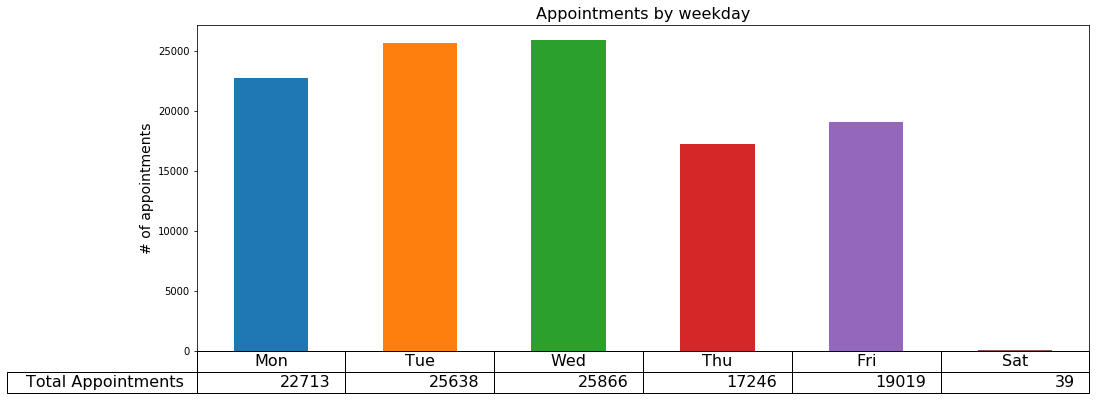

In [30]:
weekday_fig = by_weekday.AppointmentId.count().rename({0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).rename('Total Appointments').plot.bar(table=True, figsize=(16,6))
weekday_fig.tables[0].set_fontsize(16)
weekday_fig.tables[0].scale(xscale=1, yscale=1.75)
weekday_fig.xaxis.set_visible(False)
weekday_fig.set_title('Appointments by weekday', fontsize=16)
weekday_fig.set_ylabel('# of appointments', fontsize=14)

The data indicates that there are rare occurrences of appointments on Saturdays, and none on Sundays.

### Attendance Rates

Now let's take a look on what are the attendance rates on several attributes:

Text(0,0.5,'# of schedules')

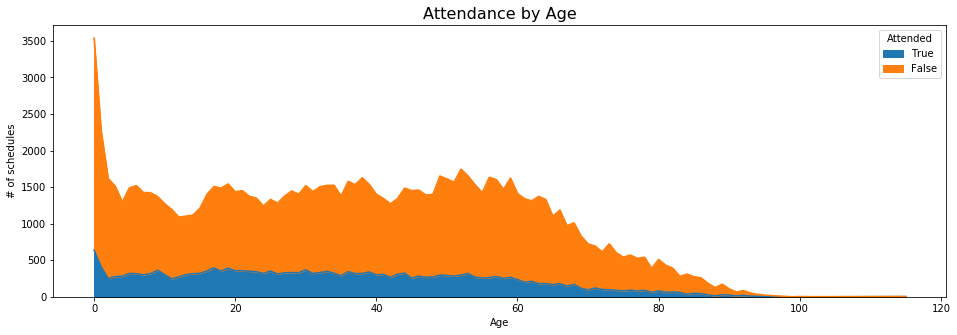

In [31]:
attended_appointments.groupby(['Age', 'Attended']).AppointmentId.count().unstack().rename({0: True, 1: False}, axis=1).plot.area(figsize=(16,5))
plt.title('Attendance by Age', fontsize=16)
plt.ylabel('# of schedules')

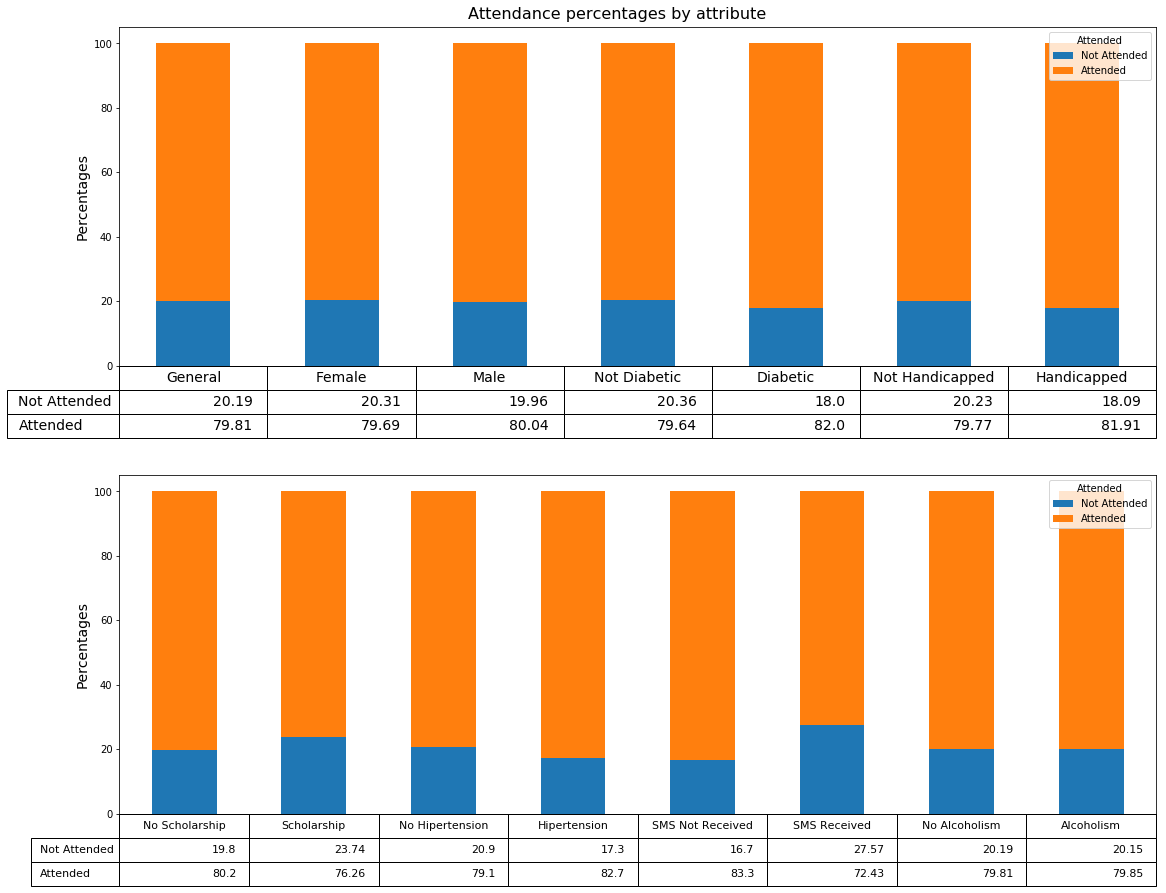

In [32]:
fig, axarr = plt.subplots(2, 1, figsize=(16, 12))
plt.suptitle('Attendance percentages by attribute', fontsize=16)
ax1 = pd.concat([
    pd.DataFrame(attended_appointments.groupby(['Attended'])['AppointmentId'].count().apply(lambda x: round(100 * x / attended_appointments.AppointmentId.count(),2))).rename({'AppointmentId':'General'}, axis=1).transpose(),
    attended_appointments.groupby(['Attended', 'Gender'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({'F': 'Female', 'M':'Male'}, axis=1).transpose(), 
    attended_appointments.groupby(['Attended', 'Diabetes'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({0:'Not Diabetic', 1:'Diabetic'}, axis=1).transpose(),
    attended_appointments.groupby(['Attended', 'Handicap'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({0:'Not Handicapped', 1:'Handicapped'}, axis=1).transpose(),
], axis=0).rename({0:'Not Attended', 1:'Attended'}, axis=1).plot.bar(ax=axarr[0], table=True, stacked=True)
# axarr[0].legend(ncol=2)
ax1.xaxis.set_visible(False) 
ax1.tables[0].scale(xscale=1, yscale=1.75)
ax1.tables[0].set_fontsize(16)
ax1.set_ylabel('Percentages', fontsize=14)

ax2 = pd.concat([
    attended_appointments.groupby(['Attended', 'Scholarship'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({0:'No Scholarship', 1:'Scholarship'}, axis=1).transpose(),
    attended_appointments.groupby(['Attended', 'Hipertension'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({0:'No Hipertension', 1:'Hipertension'}, axis=1).transpose(),
    attended_appointments.groupby(['Attended', 'SMSReceived'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({0:'SMS Not Received', 1:'SMS Received'}, axis=1).transpose(),
    attended_appointments.groupby(['Attended', 'Alcoholism'])['AppointmentId'].count().unstack().apply(lambda x: round(100 * x / x.sum(),2)).rename({0:'No Alcoholism', 1:'Alcoholism'}, axis=1).transpose(),
    
], axis=0).rename({0:'Not Attended', 1:'Attended'}, axis=1).plot.bar(ax=axarr[1], table=True,  stacked=True)
# axarr[1].legend(ncol=2)
ax2.xaxis.set_visible(False) 
ax2.tables[0].scale(xscale=1, yscale=1.75)
ax2.tables[0].set_fontsize(16)
ax2.set_ylabel('Percentages', fontsize=14)

fig.tight_layout(h_pad = 10, pad=3.4)



<a id='conclusions'></a>
## Conclusions

The data sample consists of more than 100,000 records of scheduled appointments in the health public system for Vitoria, Brazil. By analyzing the data, I was able to reach the following conclusions:

- The median days between scheduling and appointment is 4 days. This does not take in consideration that there are almost no scheduling for appointments on weekends, which can increase the waiting time;
- There is no apparent correlation between the number of appointments from a neighbourhood and the waiting times for that region;
- There are no clear busier days on the week - but apparently there are no appointments on weekends, or they are made only for Saturday in exceptional circumstances;
- The general attendance rate is around 79%;
- There is a clear difference on appointment rates between genders: Female patients are responsible for 64% of the appointments, while male patients only correspond to 36%;
- Besides the differences between the appointment rates among genders, the attendance rate is similar: around 80%, which is consistent with the general attendance rate;
- The attendance rate for the various attributes is consistent with the general rate, with the exception of the SMS message: The appointments for patients that received a message have a higher no-show rate than the ones where no message was sent.


## Limitations

There are some limitations presented by the data presented, like:

- Handicap data: the data presented has more distinct values than what was specified. I made some assumptions, but the ideal would be to recheck those data or the data specification to be sure of the valid values;
- Besides not having appointments scheduled on Sundays - and very few on Saturday, it is impossible to attest that the waiting time would be smaller if those days were available for assignment;
- There is no information about the reasons for the interval between the scheduling and the appointment days. I named this interval as 'waiting time,' but this does not adequately cover when the patient requests this timespan.